<a href="https://colab.research.google.com/github/team-epoch/EPOCH_4th_TASK/blob/main/4th_TASK/DevelopTeam/Pilot/week3/4%EA%B8%B0_%EC%9D%B4%EC%A7%80%EC%9C%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Pilot Project Week2
> **주제: 신용카드 소비 패턴으로 고객 군집화**

* 데이터 소스 : Kaggle – “Credit Card Dataset for Clustering”
> **금융 데이터를 기반으로 소비자를 군집화한 뒤, 소비자 행동/리스크를 설명**

>**도출해낼 수 있는 인사이트**

* 고객군 정의

* 맞춤형 상품/마케팅 전략 수립

* 신용 리스크 관리 ✅

* 고객 유지/이탈 방지

* 사회적 소비 트렌드 변화 파악

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import chi2

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/EPOCH/EPOCH 4th/Build-Up/CC GENERAL.csv')
data = pd.read_csv('/content/drive/MyDrive/EPOCH/EPOCH 4th/Build-Up/data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        8950 non-null   int64  
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  PURCHA

## 최적의 k 값 찾기(실루엣 계수)

In [5]:
# 탐색할 k 범위 지정
k_range = range(2, 11)  # k=2 ~ 10까지
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)  # 클러스터 라벨 예측
    score = silhouette_score(data, labels)
    silhouette_scores.append(score)
    print(f"k={k}, Silhouette Score={score:.4f}")

# 최적 k 찾기
best_k = k_range[np.argmax(silhouette_scores)]
print(f"최적의 k 값: {best_k}, 실루엣 계수: {max(silhouette_scores):.4f}")

k=2, Silhouette Score=0.6213
k=3, Silhouette Score=0.6251
k=4, Silhouette Score=0.5880
k=5, Silhouette Score=0.5689
k=6, Silhouette Score=0.5566
k=7, Silhouette Score=0.5592
k=8, Silhouette Score=0.5515
k=9, Silhouette Score=0.5458
k=10, Silhouette Score=0.5416
최적의 k 값: 3, 실루엣 계수: 0.6251


* 시각화

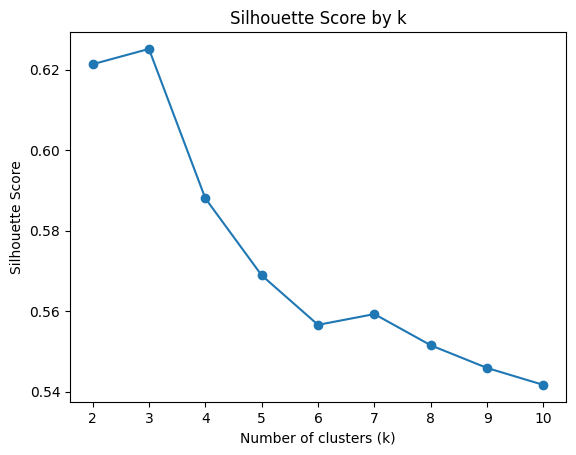

In [6]:
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by k")
plt.show()

**k=3이 best!**

*비지도 학습은 정답이 없는 데이터를 다루기 때문에 데이터셋 분할이 필수적이지 않음*

## ✅ K-means

In [7]:
k = 3  # 원하는 군집 수
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
labels = kmeans.fit_predict(data)

# 클러스터 라벨 붙이기
kmeans_clustered = data.copy()
kmeans_clustered["cluster"] = labels

# 4) 클러스터별 특징(평균값)
cluster_profile = kmeans_clustered.groupby("cluster").mean(numeric_only=True)
print("=== 클러스터별 평균 특징 ===")
print(cluster_profile)

# 필요하면 중앙값/표준편차도 같이 확인 가능
kmeans_cluster_median = kmeans_clustered.groupby("cluster").median(numeric_only=True)
k_means_cluster_std = kmeans_clustered.groupby("cluster").std(numeric_only=True)

print("\n=== 클러스터별 중앙값 ===")
print(kmeans_cluster_median)
print("\n=== 클러스터별 표준편차 ===")
print(k_means_cluster_std)

=== 클러스터별 평균 특징 ===
         Unnamed: 0   BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
cluster                                                                         
0        2238.53652  0.570909          -0.897432   0.829530          1.284471   
1        6713.50000  0.146573          -1.311810   0.369727          0.635842   
2        2075.00000  0.255026          -1.636364  -0.337479         -0.065794   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                      0.812316      1.015373             0.000081   
1                      0.562226      0.741234            -0.023146   
2                     -0.189912      4.998645            -0.490909   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  ...  \
cluster                                                                ...   
0                          0.540442                          0.2546

In [8]:
print(kmeans_clustered["cluster"].value_counts())

cluster
0    4477
1    4472
2       1
Name: count, dtype: int64


*cluster 2에 샘플이 한 개뿐..이네?*

## ✅ DBSCAN

In [9]:
# DBSCAN 모델링
dbscan = DBSCAN(eps=0.8, min_samples=10, metric="euclidean", n_jobs=-1)
labels = dbscan.fit_predict(data)  # -1: 노이즈

# 결과 요약
dbscan_clustered = data.copy()
dbscan_clustered["cluster"] = labels
sizes = dbscan_clustered["cluster"].value_counts().sort_index()
print("클러스터 크기(노이즈=-1):\n", sizes)

# 4) 노이즈 제외 프로파일(평균)
profile = (
    dbscan_clustered[dbscan_clustered["cluster"] != -1]
      .groupby("cluster")
      .mean(numeric_only=True)
      .sort_index()
)
print("\n클러스터별 평균(노이즈 제외):\n", profile)

클러스터 크기(노이즈=-1):
 cluster
-1    8950
Name: count, dtype: int64

클러스터별 평균(노이즈 제외):
 Empty DataFrame
Columns: [Unnamed: 0, BALANCE, BALANCE_FREQUENCY, PURCHASES, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES, CASH_ADVANCE, PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, CASH_ADVANCE_FREQUENCY, CASH_ADVANCE_TRX, PURCHASES_TRX, CREDIT_LIMIT, PAYMENTS, MINIMUM_PAYMENTS, PRC_FULL_PAYMENT, TENURE, real_pay, risk, overpay]
Index: []

[0 rows x 21 columns]


*모든 샘플이 노이즈(-1)로 분류가 되었다 ,,*

## PCA

In [10]:
# 1) 누적 설명분산이 90%가 될 때까지 자동으로 컴포넌트 선택
pca_auto = PCA(n_components=0.90, svd_solver="full", random_state=42)
X_pca_auto = pca_auto.fit_transform(data)

print(f"[AUTO] 선택된 주성분 개수: {pca_auto.n_components_}")
print(f"[AUTO] 누적 설명분산비: {pca_auto.explained_variance_ratio_.sum():.3f}")

# 2) 시각화/클러스터링 편의를 위한 2차원 투영 (옵션)
pca_2d = PCA(n_components=2, svd_solver="full", random_state=42)
X_pca_2d = pca_2d.fit_transform(data)

print(f"[2D] 설명분산비: {pca_2d.explained_variance_ratio_.round(3)}")

[AUTO] 선택된 주성분 개수: 2
[AUTO] 누적 설명분산비: 1.000
[2D] 설명분산비: [0.507 0.493]


*컬럼이 21개인데 2개의 주성분으로 모든 변수가 설명 가능*

특성들 간의 선형결합이 심했던 것 ➡️ **극단적인 다중공선성**

## ✅ PCA 기반 K-means

In [11]:
# PCA로 변환된 데이터 사용
X_pca = X_pca_auto

# 1) 최적 k 찾기 (실루엣 계수)
k_range = range(2, 11)
sil_scores = {}
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores[k] = sil
    print(f"k={k}, silhouette={sil:.3f}")

best_k = max(sil_scores, key=sil_scores.get)
print("최적 k:", best_k)

# 2) 최적 k로 최종 KMeans 학습
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_pca)

# 3) 라벨을 원본 데이터프레임에 붙이기
df_kmeans = data.copy()
df_kmeans["cluster"] = labels_kmeans
print(df_kmeans["cluster"].value_counts())

k=2, silhouette=0.987
k=3, silhouette=0.625
k=4, silhouette=0.588
k=5, silhouette=0.589
k=6, silhouette=0.571
k=7, silhouette=0.559
k=8, silhouette=0.551
k=9, silhouette=0.546
k=10, silhouette=0.541
최적 k: 2
cluster
0    8949
1       1
Name: count, dtype: int64


In [12]:
df_kmeans[df_kmeans["cluster"] == 1]

,Unnamed: 0,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,real_pay,risk,overpay,cluster
2075,2075,0.255026,-1.636364,-0.337479,-0.065794,-0.189912,4.998645,-0.490909,0.025253,-0.222223,...,-0.375,0.0,2.08553,0.342722,0.875001,11.0,237895.691701,-0.090594,4.067631,1


*2075번째 샘플(극단적 이상치로 판단)을 삭제하고 다시 해보자*

In [13]:
data_2075 = data.drop(index=2075)

PCA

In [14]:
# 1) 누적 설명분산이 90%가 될 때까지 자동으로 컴포넌트 선택
pca_auto = PCA(n_components=0.90, svd_solver="full", random_state=42)
X_pca_auto = pca_auto.fit_transform(data_2075)

print(f"[AUTO] 선택된 주성분 개수: {pca_auto.n_components_}")
print(f"[AUTO] 누적 설명분산비: {pca_auto.explained_variance_ratio_.sum():.3f}")

# 2) 시각화/클러스터링 편의를 위한 2차원 투영 (옵션)
pca_2d = PCA(n_components=2, svd_solver="full", random_state=42)
X_pca_2d = pca_2d.fit_transform(data_2075)

print(f"[2D] 설명분산비: {pca_2d.explained_variance_ratio_.round(3)}")

[AUTO] 선택된 주성분 개수: 1
[AUTO] 누적 설명분산비: 0.934
[2D] 설명분산비: [0.934 0.066]


K-means

In [27]:
# PCA로 변환된 데이터 사용
X_pca = X_pca_auto

# 1) 최적 k 찾기 (실루엣 계수)
k_range = range(2, 11)
sil_scores = {}
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores[k] = sil
    print(f"k={k}, silhouette={sil:.3f}")

best_k = max(sil_scores, key=sil_scores.get)
print("최적 k:", best_k)

# 2) 최적 k로 최종 KMeans 학습
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_pca)

# 3) 라벨을 원본 데이터프레임에 붙이기
df_kmeans = data_2075.copy()
df_kmeans["cluster"] = labels_kmeans
print(df_kmeans["cluster"].value_counts())

k=2, silhouette=0.627
k=3, silhouette=0.590
k=4, silhouette=0.572
k=5, silhouette=0.561
k=6, silhouette=0.554
k=7, silhouette=0.548
k=8, silhouette=0.544
k=9, silhouette=0.541
k=10, silhouette=0.538
최적 k: 2
cluster
0    2263
2    2239
1    2225
3    2222
Name: count, dtype: int64


## ✅ PCA 기반 DBSCAN

In [28]:
# PCA 데이터 사용
X_pca = X_pca_auto

# 1) DBSCAN 학습
dbscan = DBSCAN(eps=5, min_samples=10, n_jobs=-1)
labels_dbscan = dbscan.fit_predict(X_pca)

# 2) 라벨 요약
df_dbscan = data_2075.copy()
df_dbscan["cluster"] = labels_dbscan
print("클러스터 분포 (노이즈=-1):")
print(df_dbscan["cluster"].value_counts().sort_index())


클러스터 분포 (노이즈=-1):
cluster
-1       1
 0     329
 1    1747
 2    1482
 3     893
 4    2072
 5    2425
Name: count, dtype: int64


In [29]:
mask = labels_dbscan != -1
if len(set(labels_dbscan[mask])) > 1:   # 클러스터가 2개 이상 있어야 계산 가능
    sil = silhouette_score(X_pca[mask], labels_dbscan[mask])
    print(f"실루엣 계수 (노이즈 제외): {sil:.3f}")
else:
    print("⚠️ 유효 클러스터가 2개 이상 있어야 실루엣 계수를 계산할 수 있습니다.")

실루엣 계수 (노이즈 제외): 0.466


*eps=5로 설정해야 다수의 샘플이 노이즈로 분류되지 않고, 적절한 클러스터 개수로 클러스터링이 되는데 K-means 보다 실루엣 계수가 낮음*

## 시각화

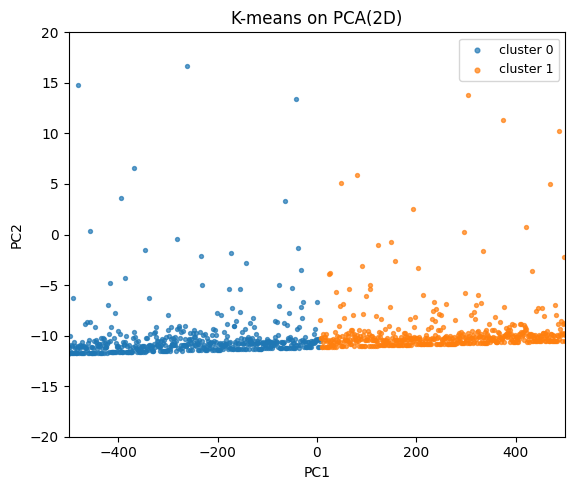

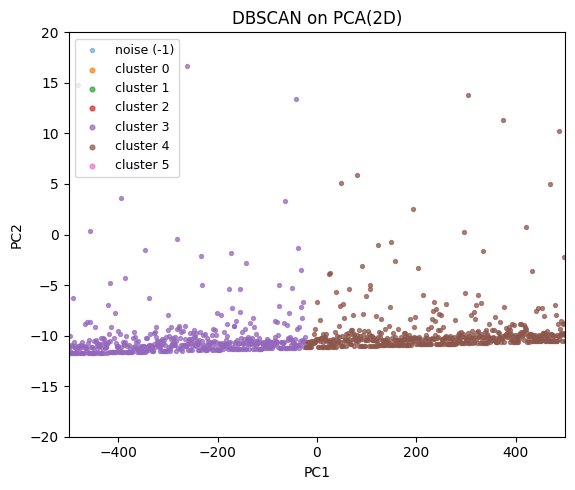

In [68]:
# ===== 준비: 2D 임베딩 =====
# 이미 만들어 둔 2차원 PCA 결과가 있다면 사용
X_pca2d = X_pca_2d  # (n_samples, 2)


# ===== 공통 유틸 =====
def plot_clusters_2d(X2d, labels, title, centroids=None):
    """
    X2d: (n,2) 2D 좌표
    labels: 클러스터 라벨 (DBSCAN의 노이즈는 -1)
    centroids: (k,2) 센트로이드 좌표 (옵션: K-means용)
    """
    X2d = np.asarray(X2d)
    labels = np.asarray(labels)

    plt.figure(figsize=(6,5))
    # 노이즈(-1) 먼저 회색으로
    noise_mask = (labels == -1)
    if noise_mask.any():
        plt.scatter(X2d[noise_mask,0], X2d[noise_mask,1],
                    s=6, alpha=0.4, label="noise (-1)")

    # 나머지 클러스터
    for c in sorted(np.unique(labels[labels!=-1])):
        m = (labels == c)
        plt.scatter(X2d[m,0], X2d[m,1], s=8, alpha=0.7, label=f"cluster {c}")

    # K-means 센트로이드가 있으면 표시(별표)
    if centroids is not None:
        centroids = np.asarray(centroids)
        plt.scatter(centroids[:,0], centroids[:,1],
                    marker="*", s=200, edgecolor="k", linewidths=0.8,
                    label="centroids")

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc="best", fontsize=9, markerscale=1.2, frameon=True)
    plt.tight_layout()
    plt.xlim(-500, 500)   # PC1 범위를 제한
    plt.ylim(-20, 20)     # PC2 범위를 제한
    plt.show()

# ===== 1) K-means 시각화 =====
# kmeans는 PCA 2D 데이터로 학습했다고 가정 (권장)
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_pca2d)
centers_2d = kmeans.cluster_centers_
plot_clusters_2d(X_pca2d, labels_kmeans, title="K-means on PCA(2D)")

# ===== 2) DBSCAN 시각화 =====
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=5, min_samples=10, n_jobs=-1)
# labels_dbscan = dbscan.fit_predict(X_pca2d)

plot_clusters_2d(X_pca2d, labels_dbscan, title="DBSCAN on PCA(2D)")


*시각화가 이상하네,,*

**이상치 감지한 뒤 K-means 학습에서 제외**

In [62]:
def robust_z(x):
    x = np.asarray(x, float)
    med = np.median(x); mad = np.median(np.abs(x - med))
    if mad == 0: return np.zeros_like(x)
    return 0.6745 * (x - med) / mad

def detect_outliers_in_pca(X_pca, z_thresh=6.0, use_mahal=True, mahal_q=0.999):
    Z = np.column_stack([robust_z(X_pca[:, j]) for j in range(X_pca.shape[1])])
    rule1 = (np.abs(Z) > z_thresh).any(axis=1)
    if not use_mahal:
        return rule1
    mu = X_pca.mean(axis=0)
    S = np.cov(X_pca, rowvar=False)
    Sinv = np.linalg.pinv(S)
    diff = X_pca - mu
    m2 = np.einsum("ij,jk,ik->i", diff, Sinv, diff)
    cut = chi2.ppf(mahal_q, df=X_pca.shape[1])
    rule2 = m2 > cut
    return rule1 | rule2

def kmeans_outlier_pipeline_with_plot(
    df_numeric: pd.DataFrame,
    k=4,
    pca_components=2,   # 모델 학습용 PCA 누적분산
    z_thresh=6.0,
    use_mahal=True,
    mahal_q=0.999,
    random_state=42,
    n_init=20,
    point_size=8,
    alpha=0.7,
):
    # ===== 0) 전처리 =====
    X = df_numeric.to_numpy(dtype=float)
    X[~np.isfinite(X)] = np.nan
    imputer = SimpleImputer(strategy="median")
    X_imp = imputer.fit_transform(X)
    scaler = RobustScaler()
    Xs = scaler.fit_transform(X_imp)

    # ===== 1) 모델 학습용 PCA =====
    pca_model = PCA(n_components=pca_components, svd_solver="full", random_state=random_state)
    X_pca = pca_model.fit_transform(Xs)

    # ===== 2) 이상치 감지 & 분리 =====
    outlier_mask = detect_outliers_in_pca(X_pca, z_thresh=z_thresh, use_mahal=use_mahal, mahal_q=mahal_q)
    keep_mask = ~outlier_mask

    # ===== 3) K-means (이상치 제외) =====
    km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
    labels_keep = km.fit_predict(X_pca[keep_mask])

    labels_all = np.full(X.shape[0], -1, dtype=int)
    labels_all[keep_mask] = labels_keep

    # ===== 4) 요약 지표 =====
    sil = None
    uniq = np.unique(labels_keep)
    if len(uniq) >= 2:
        sil = silhouette_score(X_pca[keep_mask], labels_keep)

    # ===== 5) 시각화용 2D PCA =====
    pca_2d = PCA(n_components=2, random_state=random_state)
    X_pca2d = pca_2d.fit_transform(Xs)  # 전 데이터 2D 투영

    # 시각화용 클러스터 중심: 2D 좌표에서의 군집 평균(이상치 제외)
    centers_2d = []
    for c in sorted(np.unique(labels_keep)):
        m = (labels_all == c)
        centers_2d.append(X_pca2d[m].mean(axis=0))
    centers_2d = np.vstack(centers_2d) if len(centers_2d) else None

    # ===== 6) 그리기 =====
    plt.figure(figsize=(7,6))
    # 6-1) 이상치 회색
    if outlier_mask.any():
        plt.scatter(X_pca2d[outlier_mask,0], X_pca2d[outlier_mask,1],
                    s=point_size, alpha=0.25, label="outlier (-1)")

    # 6-2) 정상 클러스터
    for c in sorted(np.unique(labels_all[labels_all!=-1])):
        m = labels_all == c
        plt.scatter(X_pca2d[m,0], X_pca2d[m,1], s=point_size, alpha=alpha, label=f"cluster {c}")

    # 6-3) 중심 ★
    if centers_2d is not None and centers_2d.size:
        plt.scatter(centers_2d[:,0], centers_2d[:,1],
                    marker="*", s=220, edgecolor="k", linewidths=0.8, label="centroid")

    plt.title("K-means on PCA (2D) with outliers")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(loc="best", fontsize=9, markerscale=1.2, frameon=True)
    plt.xlim(-15, 10)   # PC1 범위를 제한
    plt.ylim(-10, 15)     # PC2 범위를 제한
    plt.tight_layout()
    plt.show()

    # ===== 7) 결과 반환 =====
    out = df_numeric.copy()
    out["cluster"] = labels_all
    out["is_outlier"] = outlier_mask
    summary = {
        "pca_model_components_": int(pca_model.n_components_),
        "pca_model_var_ratio_sum": float(pca_model.explained_variance_ratio_.sum()),
        "n_outliers": int(outlier_mask.sum()),
        "cluster_sizes_incl_outliers": out["cluster"].value_counts().sort_index().to_dict(),
        "silhouette_excluding_outliers": sil,
    }
    objs = {"imputer": imputer, "scaler": scaler, "pca_model": pca_model, "pca_2d": pca_2d, "kmeans": km}
    return out, summary, objs

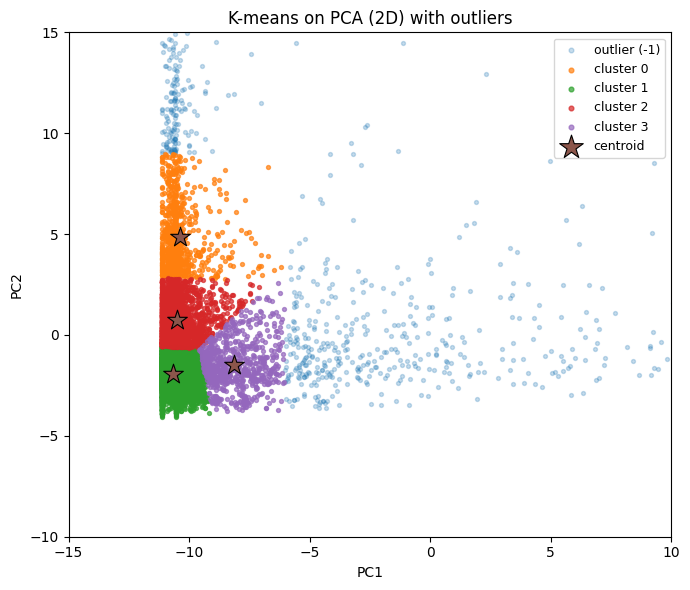

{'pca_model_components_': 2, 'pca_model_var_ratio_sum': 0.9999009374105222, 'n_outliers': 778, 'cluster_sizes_incl_outliers': {-1: 778, 0: 768, 1: 4476, 2: 2197, 3: 730}, 'silhouette_excluding_outliers': np.float64(0.4879060059651079)}
   Unnamed: 0   BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0           0 -0.432267          -1.636364  -0.248371         -0.065812   
1           1  1.209374          -0.818182  -0.337489         -0.065812   
2           2  0.842099           0.000000   0.384766          1.273231   
3           3  0.411913          -3.272727   1.062798          2.530286   
4           4 -0.028907           0.000000  -0.322542         -0.038102   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                0.013657      0.000000            -0.399999   
1               -0.189912      5.784542            -0.600000   
2               -0.189912      0.000000             0.600000   
3               -0.189912      0.184759            -0.500

In [63]:
# 숫자형만 준비
# num_df = data_2075.select_dtypes(include=[np.number]).copy()

clustered_df, info, objs = kmeans_outlier_pipeline_with_plot(
    data_2075, k=4, pca_components=2, z_thresh=6.0, use_mahal=True, mahal_q=0.999
)

print(info)                # PCA/이상치/실루엣/군집 크기 요약
print(clustered_df.head()) # cluster=-1은 이상치

**다음 TASK**
* `data_2075`말고 원본 데이터로도 실행해보기
* 클러스터별 특성 파악 및 인사이트 도출
* 디벨롭할 만한 요소 좀 더 찾아보기